In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

import scikitplot as skplt
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

import matplotlib.pyplot as plt
%matplotlib inline

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

In [5]:
df= pd.read_csv('./data/positive_emotion_dataset.csv').drop(columns='Unnamed: 0')
df

,ad,pos_emo
0,i am proud and excited to be your mayor\nalex ...,1
1,proud to work with rep andy kim to secure mil...,1
2,in recent days i have received many questions ...,1
3,this is a fantastic idea we need to stopkavan...,1
4,in these deeply divided times connecting commu...,1
...,...,...
19995,from maggie thatcher to theresa may i know whi...,0
19996,vote is available in many areas across north ...,0
19997,you have to register before you can vote,0
19998,dana balter would put washington bureaucrats i...,0


In [6]:
norm_train,  norm_test, y_train, y_test  = train_test_split(df['ad'], df['pos_emo'], test_size =0.2  , random_state = 42)

In [10]:
# data tokenization 
t = tf.keras.preprocessing.text.Tokenizer(oov_token='<UNK>')

# fit the tokenizer on the training documents
t.fit_on_texts(norm_train)
t.word_index['<PAD>'] = 0
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(('gro', 45809), ('<PAD>', 0), 1)

In [11]:
# create tokenized data sequences to feed to the neural network 
train_sequences = t.texts_to_sequences(norm_train)
test_sequences = t.texts_to_sequences(norm_test)

In [12]:
MAX_SEQUENCE_LENGTH = 1000

# pad documents to equal length with 0 
X_train = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((16000, 1000), (4000, 1000))

In [13]:
from tensorflow.keras.layers import Layer 
from keras import backend as K


class AttentionLayer(Layer):
    
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        
        """
            Attention Layer sourced from : https://github.com/lzfelix/keras_attention/blob/master/attention/layers.py

            Implementation based in the work of Yang et al. "Hierarchical Attention Networks for Document Classification". 
            This implementation also allows changing the common tanh activation function used on the attention layer, as Chen
            et al. "A Thorough Examination of the CNN/Daily Mail Reading Comprehension Task"
            point that removing this component can be beneficial to the model. Supports
            masking.
    
            The mathematical formulation of the model is as follows:
              ```
              u = f(W * h + b),
              a_i = softmax(u_i^T * u_s),
              v_i = \sigma_i a_i * h_i.
              ```
    
            # Arguments
                  activation: The activation function f used by the layer (see
                      [activations](../activations.md)). By default tanh is used, another common
                      option is "linear".
                  use_bias: Boolean, whether the layer uses a bias vector.
                  initializer: Initializer for the `kernel` and `context` matrices
                      (see [initializers](../initializers.md)).
                  return_attention: If True, instead of returning the sequence descriptor, this
                      layer will return the computed attention coefficients for each of the
                      sequence timesteps. See Output section for details.
                  W_regularizer: Regularizer function applied to the `kernel` weights matrix
                      (see [regularizer](../regularizers.md)).
                  u_regularizer: Regularizer function applied to the `context` weights matrix
                      (see [regularizer](../regularizers.md)).
                  b_regularizer: Regularizer function applied to the bias vector
                      (see [regularizer](../regularizers.md)).
                  W_constraint: Constraint function applied to the `kernel` weights matrix
                      (see [constraints](../constraints.md)).
                  u_constraint: Constraint function applied to the `contextl` weights matrix
                      (see [constraints](../constraints.md)).
                  b_constraint: Constraint function applied to the bias vector
                      (see [constraints](../constraints.md)).
          # Input shape
                  nD tensor with shape: `(batch_size, ..., timesteps, input_dim)`.
                  The most common situation would be a 3D input with shape
                  `(batch_size, timesteps, input_dim)`.
          # Outuput shape
                  The sequence descriptor with shape `(batch_size, ..., timestamps)`. If
                  `return_attention` is True, this layer will return the `alpha_i` weights
                  for each timestep, and consequently its output shape will be different, namely:
                  `(batch_size, ..., timesteps)`. 
        """
        
        self.supports_masking = True
        self.init = tf.keras.initializers.get('glorot_uniform')

        self.W_regularizer = tf.keras.regularizers.get(W_regularizer)
        self.b_regularizer = tf.keras.regularizers.get(b_regularizer)

        self.W_constraint = tf.keras.constraints.get(W_constraint)
        self.b_constraint = tf.keras.constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(AttentionLayer, self).__init__(**kwargs)
        

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight( shape= (input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape = (input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True
        

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    
    def call(self, x, mask=None):
        # TF backend doesn't support it
        # eij = K.dot(x, self.W) 
        # features_dim = self.W.shape[0]
        # step_dim = x._keras_shape[1]

        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), 
                              K.reshape(self.W, (features_dim, 1))),
                        (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        
        return K.sum(weighted_input, axis=1)

    
    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim
    
    
    def get_config(self):
        config = {'step_dim': self.step_dim}
        base_config = super(AttentionLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [14]:
def create_model(vocab_size, embedding_dim, max_sequence_length, gru_dim,dropout = 0.2):
  '''
    Create a Bidirectional GRU used for binary text classification task
    Arguments : 
      vocab_size: vocabulary size 
      embedding_dim: embedding dimensions for the document vector representation 
      max_sequence_length: input sequence length for each document 
      gru_dim: number of neurones in the GRU layers
      dropout : dropout rate used for Dropout regularization layers to minimize overfitting

    Returns : 
    A model with the folowing layers:  
            - Input layer to instantiate a tensor using the input preprocessed data
            - Embedding layer to represent each document with a context vector
            - Biderectional GRU (takes into consideration bidrectional context)
            - A custom attention layer that takes **all** of the output of the GRU ( not the last hidden state only)
            - Dense layer 
            - Dropout layer to minimize overfitting
            - A Dense layer 
            - Dropout 
            - An output layer to get the label of the class 
  '''
  model = Sequential([
      layers.Input(shape=(max_sequence_length,)),
      layers.Embedding(vocab_size, embedding_dim, trainable=True),
      layers.Bidirectional(layers.GRU(gru_dim, return_sequences=True)),
      AttentionLayer(max_sequence_length),
      layers.Dense(gru_dim*2, activation='relu'),
      layers.Dropout( rate = dropout ),
      layers.Dense(gru_dim, activation='relu'),
      layers.Dropout( rate = dropout ),
      layers.Dense(1, activation='sigmoid')              
  ])
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
  return model

In [15]:
EMBEDDING_DIM = 128 # dimension for dense embeddings for each token
GRU_DIM = 128 # total units in the GRU layer
VOCAB_SIZE = len(t.word_index)

# Create the model
model = create_model(vocab_size = VOCAB_SIZE, embedding_dim = EMBEDDING_DIM, max_sequence_length = MAX_SEQUENCE_LENGTH, gru_dim = GRU_DIM)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 128)         5863680   
                                                                 
 bidirectional (Bidirectiona  (None, 1000, 256)        198144    
 l)                                                              
                                                                 
 attention_layer (AttentionL  (None, 256)              1256      
 ayer)                                                           
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               3

In [16]:
# model training 
batch_size = 32
model.fit(X_train, y_train, epochs= 5, batch_size=batch_size, 
          shuffle=True, validation_split=0.2, verbose=1)

Epoch 1/5
400/400 [==============================] - 137s 319ms/step - loss: 0.3922 - accuracy: 0.7912 - val_loss: 0.1157 - val_accuracy: 0.9616
Epoch 2/5
400/400 [==============================] - 127s 319ms/step - loss: 0.0797 - accuracy: 0.9771 - val_loss: 0.0864 - val_accuracy: 0.9744
Epoch 3/5
400/400 [==============================] - 127s 318ms/step - loss: 0.0244 - accuracy: 0.9930 - val_loss: 0.0900 - val_accuracy: 0.9703
Epoch 4/5
400/400 [==============================] - 126s 315ms/step - loss: 0.0089 - accuracy: 0.9983 - val_loss: 0.1028 - val_accuracy: 0.9784
Epoch 5/5
400/400 [==============================] - 126s 316ms/step - loss: 0.0030 - accuracy: 0.9991 - val_loss: 0.1280 - val_accuracy: 0.9784


In [17]:
# model evaluation 
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

125/125 [==============================] - 16s 128ms/step - loss: 0.1544 - accuracy: 0.9750
Accuracy: 97.50%


In [18]:
# get model predictions 
prediction_probs = model.predict(X_test, verbose=1).ravel()
predictions = [1 if prob > 0.5 else 0 for prob in prediction_probs]
predictions[:10]

125/125 [==============================] - 14s 106ms/step


[1, 0, 1, 0, 0, 0, 0, 1, 1, 1]

              precision    recall  f1-score   support

      no-POS       0.96      0.98      0.97      1945
         POS       0.99      0.97      0.98      2055

    accuracy                           0.97      4000
   macro avg       0.97      0.98      0.97      4000
weighted avg       0.98      0.97      0.98      4000

confusion matrix:
[[1915   30]
 [  70 1985]]



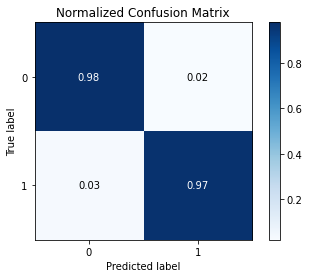

In [19]:
from sklearn import metrics

print(metrics.classification_report(y_test, predictions, target_names=['no-POS', 'POS']))

print("confusion matrix:")
print(metrics.confusion_matrix(y_test, predictions))
print()

skplt.metrics.plot_confusion_matrix(y_test, predictions , normalize=True)
plt.show()

In [7]:
# save the test results 
save = pd.read_csv('./data/sample_pos_emo.csv')
save

,ad,pos_emo
0,see why everyone is celebrating at hoblit dodg...,1
1,help give people without a home a chance to le...,0
2,i am so proud of what this grassroots team has...,1
3,we have until march 31st to raise money for ou...,0
4,learn how to use the new staffing law to impro...,0
...,...,...
120,blood donation saves lives\nthis cannot be sai...,0
121,over 10000 palestinians have been forced left ...,0
122,palestine emergency appeal 53 palestinians inc...,0
123,let is build cameroon wake up cameroonians and...,1


In [20]:
norm_ = save['ad']
test_ = t.texts_to_sequences(norm_)
padded_ = tf.keras.preprocessing.sequence.pad_sequences(test_, maxlen=MAX_SEQUENCE_LENGTH)

scores = model.evaluate(padded_, save['pos_emo'], verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

4/4 [==============================] - 2s 147ms/step - loss: 4.4750 - accuracy: 0.7200
Accuracy: 72.00%


confusion matrix:
[[84 14]
 [21  6]]



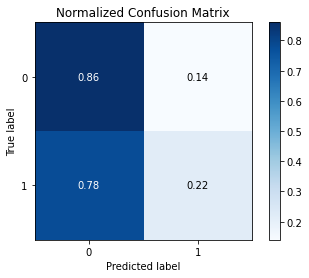

In [21]:
val_ = t.texts_to_sequences(norm_)
padded_val = tf.keras.preprocessing.sequence.pad_sequences(val_, maxlen=MAX_SEQUENCE_LENGTH)
pred_ =  model.predict(padded_val)
save['predicted'] = [1 if prob > 0.5 else 0 for prob in pred_]

print("confusion matrix:")
print(metrics.confusion_matrix(save['pos_emo'], save['predicted']))
print()

skplt.metrics.plot_confusion_matrix(save['pos_emo'], save['predicted'], normalize=True)
plt.show()

In [22]:
print(metrics.classification_report(save['pos_emo'], save['predicted'], target_names=[ 'no-pos', 'pos']))

              precision    recall  f1-score   support

      no-pos       0.80      0.86      0.83        98
         pos       0.30      0.22      0.26        27

    accuracy                           0.72       125
   macro avg       0.55      0.54      0.54       125
weighted avg       0.69      0.72      0.70       125

